# Prediction Results with Audio Annotations on Summary Vectronics Data

**Last Modified**: Jul 29, 2025

In this notebook, we summarize and visualize the results for behavior classification with audio annotations on summary sttaistics of Vectronics acceleration data. The training and testing data splits are created randomly for this experiment. We conduct hyperparameter tuning and look at the prediction results f the best performing model.

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm import tqdm
import json
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

sys.path.append('.')
sys.path.append('../')

from src.utils.data_prep import (combined_annotations,
                                create_max_windows,
                                create_summary_data,
                                create_data_splits,
                                adjust_behavior_and_durations,
                                setup_dataloaders,)

from src.utils.train import (train_run)
from src.utils.plots import (multi_label_predictions)

from src.methods.prediction_model import (SimpleNN)

from src.utils.io import (get_metadata_path,
                          get_video_labels_path,
                          get_audio_labels_path,
                          get_project_root,
                          get_results_dir,
                          get_matched_data_path,
                          get_matched_metadata_path
                          )

from config.settings import (SUMMARY_COLLAPSE_BEHAVIORS_MAPPING_W_TROTTING,
                             SUMMARY_COLLAPSE_BEHAVIORS_MAPPING_WO_TROTTING,
                             SUMMARY_BEHAVIORS_W_TROTTING,
                             SUMMARY_BEHAVIORS_WO_TROTTING,
                             SAMPLING_RATE,
                             id_mapping
                             )
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [92]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['text.usetex'] = False

In [93]:
# load matched acceleration and label pairs data, metadata, and summary

all_annotations = combined_annotations(video_path=get_video_labels_path(), 
                                        audio_path=get_audio_labels_path(),
                                        id_mapping=id_mapping) # load annotations 

all_annotations.Timestamp_start = pd.to_datetime(all_annotations.Timestamp_start)
all_annotations.Timestamp_end = pd.to_datetime(all_annotations.Timestamp_end)
all_annotations['duration'] = (all_annotations.Timestamp_end - all_annotations.Timestamp_start).dt.total_seconds()

In [94]:
print(all_annotations["duration"].describe())
values = [10, 20, 30]
quantiles = [np.mean(all_annotations["duration"] <= value) for value in values]
for value, q in zip(values, quantiles):
    print(f"Value {value}s is approximately at the {q:.2f}th percentile.")

count    12390.000000
mean        37.909282
std        113.595392
min          0.000000
25%          3.000000
50%          8.000000
75%         25.000000
max       2834.000000
Name: duration, dtype: float64
Value 10s is approximately at the 0.54th percentile.
Value 20s is approximately at the 0.69th percentile.
Value 30s is approximately at the 0.76th percentile.


In [95]:
metadata = pd.read_csv(get_metadata_path())

In [96]:
training_results_dir = os.path.join(get_results_dir(), 'training_results')
os.makedirs(training_results_dir, exist_ok=True)
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")
feature_cols = [
    'acc_x_ptp_max', 'acc_x_ptp_mean', 'acc_x_mean',
    'acc_y_ptp_max', 'acc_y_ptp_mean','acc_y_mean',
    'acc_z_ptp_max', 'acc_z_ptp_mean', 'acc_z_mean',
]

In [99]:
from dataclasses import dataclass, field
from typing import  List

@dataclass
class TrainArgs:
    batch_size: int = 512
    num_epochs: int = 100
    theta: float = 0.5
    learning_rate: float = 0.001
    weight_decay: float = 0.0001
    print_freq: int = 10
    verbose: bool = False

@dataclass
class ModelArgs:
    hidden_layers: List[int] = field(default_factory=lambda: [64])
    dropout_rate: float = 0.5

@dataclass
class DataArgs:
    window_duration: float = 30.0

train_args = TrainArgs()
model_args = ModelArgs()
data_args = DataArgs()

In [100]:
label_encoder = LabelEncoder()
label_encoder.fit(SUMMARY_BEHAVIORS_WO_TROTTING)

LabelEncoder()

In [147]:
acc_data = pd.read_csv(get_matched_data_path())
acc_data_metadata = pd.read_csv(get_matched_metadata_path())

acc_data['acc_x'] = acc_data['acc_x'].apply(json.loads)
acc_data['acc_y'] = acc_data['acc_y'].apply(json.loads)
acc_data['acc_z'] = acc_data['acc_z'].apply(json.loads)

acc_data = adjust_behavior_and_durations(acc_data, SUMMARY_COLLAPSE_BEHAVIORS_MAPPING_WO_TROTTING, SUMMARY_BEHAVIORS_WO_TROTTING)
acc_data_metadata = acc_data_metadata.loc[acc_data.index]

acc_data.reset_index()
acc_data_metadata.reset_index()

print(np.percentile(acc_data.duration, 50))

# Group and sum durations in hours
duration_table = acc_data.groupby(['Source', 'behavior'])['duration'].sum().div(3600)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print(duration_df)

12.937
behavior   Feeding    Moving   Running  Stationary
Source                                            
Audio     0.406941  1.559753  1.141878    0.000000
Video     1.318418  1.670032  0.093556   68.015672
Total     1.725360  3.229784  1.235434   68.015672


#### 1. Min Duration = 10 seconds

In [51]:
window_duration = 10.0
acc_data_split = create_max_windows(acc_data=acc_data, window_duration=window_duration, sampling_rate=SAMPLING_RATE)
acc_data_split = acc_data_split[acc_data_split.duration >= window_duration]

# Group and sum durations in hours
duration_table = acc_data_split.groupby(['Source', 'behavior'])['duration'].sum().div(3600)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print(f"Window duration = {window_duration}")
print(duration_df)

summary_acc_data_10 = create_summary_data(acc_data_split, sampling_rate=SAMPLING_RATE)

Window duration = 10.0
behavior   Feeding    Moving   Running  Stationary
Source                                            
Audio     0.388889  1.422222  1.019444    0.000000
Video     1.141667  1.258333  0.075000   61.241667
Total     1.530556  2.680556  1.094444   61.241667


In [52]:
window_duration = 20.0
acc_data_split = create_max_windows(acc_data=acc_data, window_duration=window_duration, sampling_rate=SAMPLING_RATE)
acc_data_split = acc_data_split[acc_data_split.duration >= window_duration]

# Group and sum durations in hours
duration_table = acc_data_split.groupby(['Source', 'behavior'])['duration'].sum().div(3600)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print(f"Window duration = {window_duration}")
print(duration_df)

summary_acc_data_20 = create_summary_data(acc_data_split, sampling_rate=SAMPLING_RATE)

Window duration = 20.0
behavior   Feeding    Moving   Running  Stationary
Source                                            
Audio     0.350000  1.172222  0.877778    0.000000
Video     0.927778  0.466667  0.038889   55.772222
Total     1.277778  1.638889  0.916667   55.772222


In [53]:
window_duration = 30.0
acc_data_split = create_max_windows(acc_data=acc_data, window_duration=window_duration, sampling_rate=SAMPLING_RATE)
acc_data_split = acc_data_split[acc_data_split.duration >= window_duration]

# Group and sum durations in hours
duration_table = acc_data_split.groupby(['Source', 'behavior'])['duration'].sum().div(3600)

# Convert to a pivot table: behaviors as rows, sources as columns
duration_df = duration_table.unstack(fill_value=0)

# Add a row for total duration per source
duration_df.loc['Total'] = duration_df.sum()

print(f"Window duration = {window_duration}")
print(duration_df)

summary_acc_data_30 = create_summary_data(acc_data_split, sampling_rate=SAMPLING_RATE)

Window duration = 30.0
behavior  Feeding    Moving   Running  Stationary
Source                                           
Audio       0.325  0.991667  0.750000    0.000000
Video       0.750  0.225000  0.016667   51.566667
Total       1.075  1.216667  0.766667   51.566667


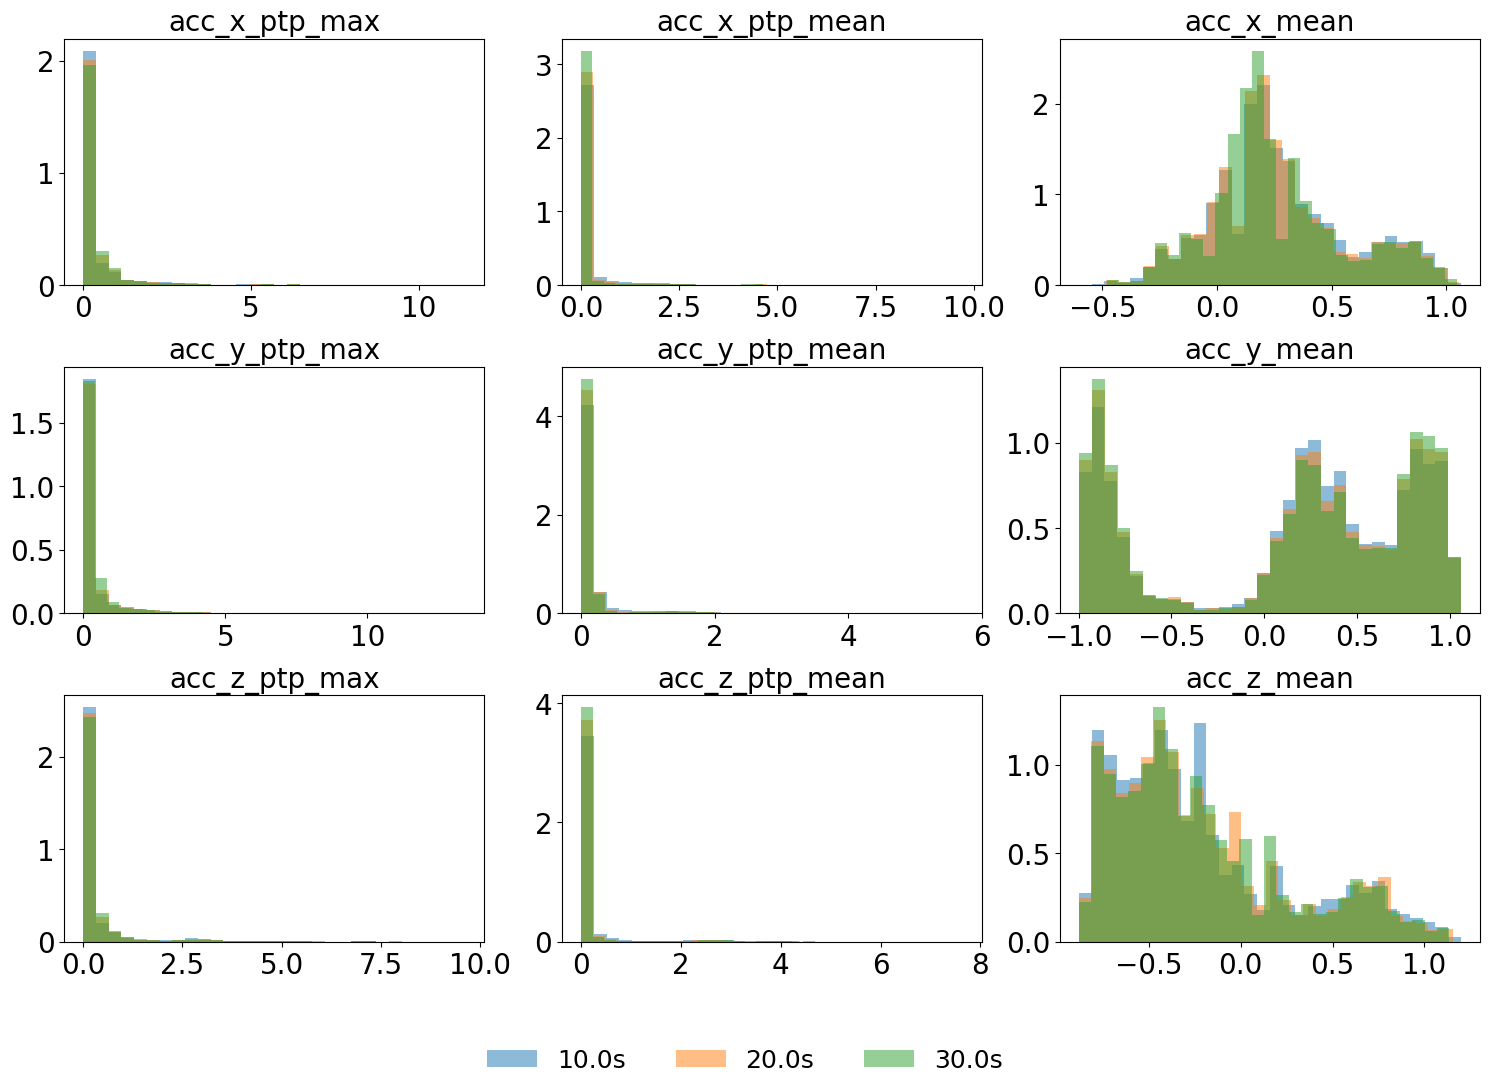

In [58]:
window_durations = [10.0, 20.0, 30.0]

fig, axs = plt.subplots(3, 3, figsize=(15,10))
axs = axs.flat

plot_idx = 0 

for window_duration in window_durations:

    if window_duration == 10.0:
           summary_acc_data = summary_acc_data_10
    elif window_duration == 20.0:
           summary_acc_data = summary_acc_data_20
    else:
        summary_acc_data = summary_acc_data_30

    for i, col in enumerate(feature_cols):
        axs[i].hist(summary_acc_data[col], bins=30, alpha=0.5, label=f"{window_duration}s", density=True)

for i, col in enumerate(feature_cols):
    axs[i].set_title(f"{col}")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    frameon=False,
)
plt.tight_layout()
plt.show()


In [65]:
from scipy.spatial.distance import cdist
from itertools import combinations

def rbf_kernel(X, Y, sigma=1.0):
    """Compute the RBF (Gaussian) kernel between two sets of vectors."""
    dists = cdist(X, Y, 'sqeuclidean')
    return np.exp(-dists / (2 * sigma ** 2))

def compute_mmd(X, Y, sigma=1.0):
    """Biased estimator of MMD², guaranteed to be ≥ 0."""
    K_XX = rbf_kernel(X, X, sigma)
    K_YY = rbf_kernel(Y, Y, sigma)
    K_XY = rbf_kernel(X, Y, sigma)

    mmd2 = K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()
    return mmd2

def mmd_test(X, Y, sigma=1.0, num_permutations=1000, seed=None):
    """Two-sample test using MMD with permutation test to get p-value."""
    rng = np.random.default_rng(seed)
    n, m = len(X), len(Y)
    Z = np.vstack([X, Y])
    observed_mmd = compute_mmd(X, Y, sigma=sigma)

    permuted_mmds = []
    for _ in range(num_permutations):
        idx = rng.permutation(n + m)
        X_perm = Z[idx[:n]]
        Y_perm = Z[idx[n:]]
        permuted_mmds.append(compute_mmd(X_perm, Y_perm, sigma=sigma))

    p_value = np.mean([mmd >= observed_mmd for mmd in permuted_mmds])
    return observed_mmd, permuted_mmds, p_value

def median_pairwise_distance(X, Y):
    Z = np.vstack([X, Y])
    dists = cdist(Z, Z, 'euclidean')
    return np.median(dists[np.triu_indices_from(dists, k=1)])

n, m = 2000, 2000
num_permutations = 100
seed = 42
rng = np.random.default_rng(seed)

datasets = {
            'window_10': summary_acc_data_10[feature_cols].values[rng.permutation(len(summary_acc_data_10))],
            'window_20': summary_acc_data_20[feature_cols].values[rng.permutation(len(summary_acc_data_20))],
            'window_30': summary_acc_data_30[feature_cols].values[rng.permutation(len(summary_acc_data_30))]
}

for (name1, Xs), (name2, Xt) in combinations(datasets.items(), 2):
    Xs_sub = Xs[:n, :]
    Xt_sub = Xt[:m, :]
    
    sigma = median_pairwise_distance(Xs_sub, Xt_sub)
    stat, permuted_stat, pval = mmd_test(
        X=Xs_sub,
        Y=Xt_sub,
        sigma=sigma,
        num_permutations=num_permutations,
        seed=seed
    )
    
    print(f"\nComparison: {name1} vs {name2}")
    print(f"MMD² statistic: {stat:.4f}")
    if pval < 0.05:
        print(f"P-value: {pval:.4f} - The two distributions are significantly different (reject H₀).")
    else:
        print(f"P-value: {pval:.4f} - The two distributions are not significantly different (fail to reject H₀).")



Comparison: window_10 vs window_20
MMD² statistic: 0.0010
P-value: 0.0100 - The two distributions are significantly different (reject H₀).

Comparison: window_10 vs window_30
MMD² statistic: 0.0023
P-value: 0.0000 - The two distributions are significantly different (reject H₀).

Comparison: window_20 vs window_30
MMD² statistic: 0.0006
P-value: 0.1500 - The two distributions are not significantly different (fail to reject H₀).


## 2. Training Models to Predict $Y|X$

#### 2.1 Min Duration = 10.0

In [101]:
# create summary statistics data

window_duration = 10.0
X_train, y_train, X_val, y_val, X_test, y_test = create_data_splits(summary_acc_data_10, feature_cols=feature_cols)


In [102]:
theta_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for theta in theta_list:

    train_args.theta = theta

    # setup dataloaders
    train_dataloader, val_dataloader, test_dataloader = setup_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_args)

    # setup model, loss, and optimizer
    model = SimpleNN(input_dim=X_train.shape[1], n_ouputs=len(SUMMARY_BEHAVIORS_WO_TROTTING), hidden_layers=model_args.hidden_layers, dropout_rate=model_args.dropout_rate).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)

    #### Training
    train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, train_args, device)
    model = train_obj['model'].to(device)
    training_stats = train_obj['training_stats']

    model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{train_args.theta}")
    os.makedirs(model_dir, exist_ok=True)

    torch.save(model, os.path.join(model_dir, 'model.pt'))
    json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
    with open(json_training_stats_file, 'w') as f:
        json.dump(training_stats, f)

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
    np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
    np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
    np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
    np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])
    

Epoch 100/100 | Train Loss: 0.0256 | Val Loss: 0.0198 | Best val Loss: 0.0198: 100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


Total training time: 0:00:25


Epoch 100/100 | Train Loss: 0.0394 | Val Loss: 0.0162 | Best val Loss: 0.0162: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


Total training time: 0:00:24


Epoch 100/100 | Train Loss: 0.0571 | Val Loss: 0.0162 | Best val Loss: 0.0161: 100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


Total training time: 0:00:24


Epoch 100/100 | Train Loss: 0.0670 | Val Loss: 0.0160 | Best val Loss: 0.0155: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


Total training time: 0:00:24


Epoch 100/100 | Train Loss: 0.0704 | Val Loss: 0.0170 | Best val Loss: 0.0170: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Total training time: 0:00:24


Epoch 100/100 | Train Loss: 0.0748 | Val Loss: 0.0228 | Best val Loss: 0.0222: 100%|██████████| 100/100 [00:22<00:00,  4.38it/s]

Total training time: 0:00:23


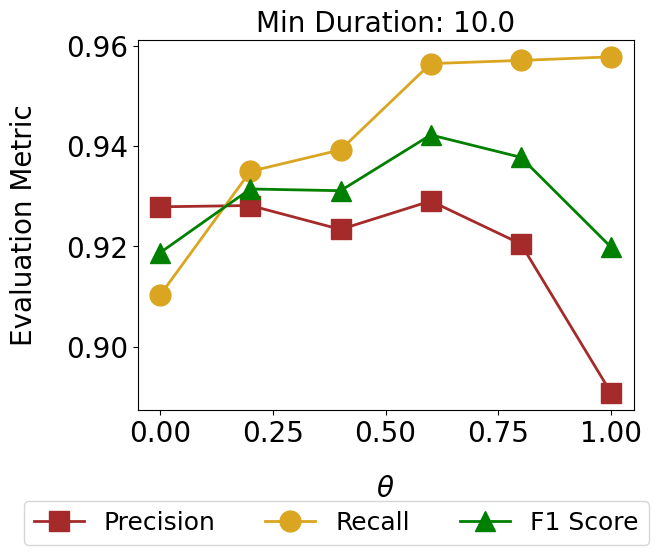

In [103]:
colors = ['brown', 'goldenrod', 'green']

precisions, recalls, f1scores = np.zeros(len(theta_list)), np.zeros(len(theta_list)), np.zeros(len(theta_list))

for j, theta in enumerate(theta_list):

    model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{theta}")

    precisions[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
    recalls[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
    f1scores[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

plt.plot(theta_list, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(theta_list, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(theta_list, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
plt.title(f"Min Duration: {window_duration}")
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)

plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.4,-0.4))
# plt.tight_layout()
plt.show()  

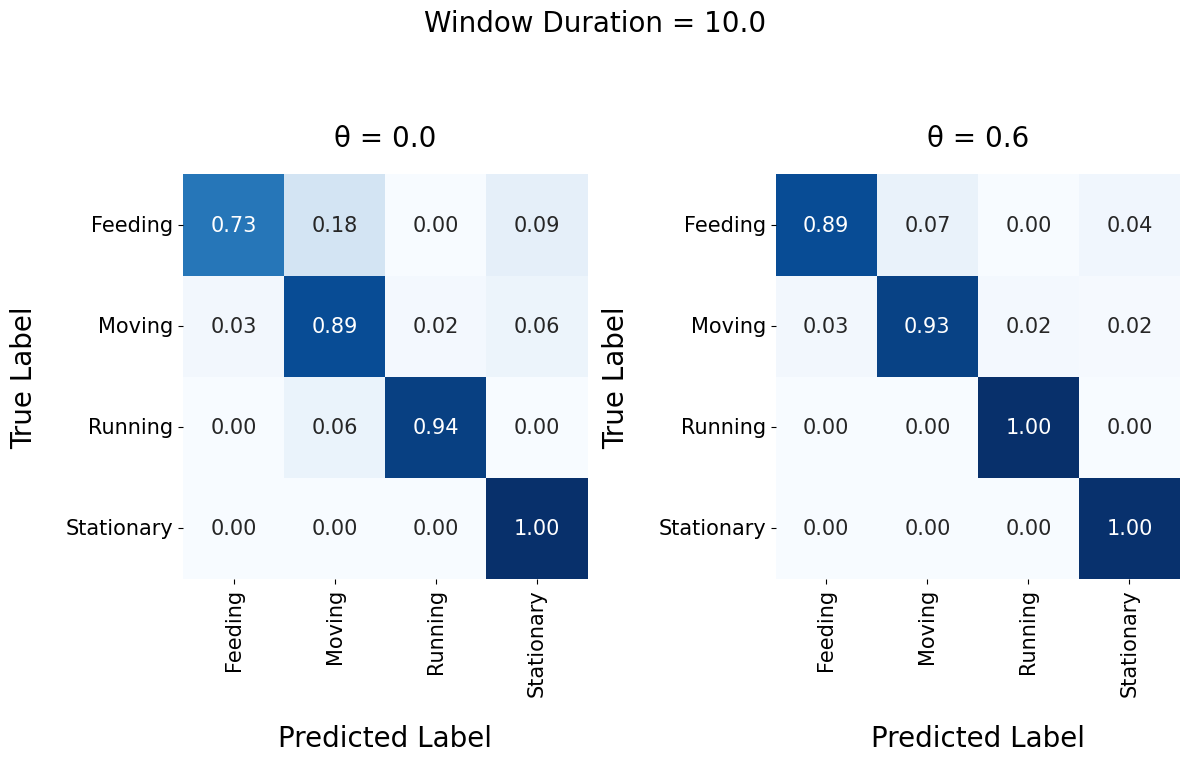

In [129]:
window_duration = 10.0
theta_list = [0.0, 0.6]
fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 8))

for i, theta in enumerate(theta_list):

    ax = axs[i]

    model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{theta}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')
    class_names = label_encoder.inverse_transform(np.arange(len(np.unique(val_true))))

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, square=True, linewidths=0,
                annot_kws={"size": 15}, ax=ax)

    ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
    ax.set_ylabel("True Label", fontsize=20, labelpad=20)
    ax.set_xticklabels(class_names, fontsize=15, rotation=90)
    ax.set_yticklabels(class_names, fontsize=15, rotation=0)
    ax.set_title(f"θ = {theta}", fontsize=20, pad=20)


fig.suptitle(f"Window Duration = {window_duration}", fontsize=20)
plt.tight_layout()
plt.show()

#### 2.2 Window Duration = 20.0

In [125]:
# create summary statistics data

window_duration = 20.0
X_train, y_train, X_val, y_val, X_test, y_test = create_data_splits(summary_acc_data_20, feature_cols=feature_cols)


In [126]:
theta_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for theta in theta_list:

    train_args.theta = theta

    # setup dataloaders
    train_dataloader, val_dataloader, test_dataloader = setup_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_args)

    # setup model, loss, and optimizer
    model = SimpleNN(input_dim=X_train.shape[1], n_ouputs=len(SUMMARY_BEHAVIORS_WO_TROTTING), hidden_layers=model_args.hidden_layers, dropout_rate=model_args.dropout_rate).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)

    #### Training
    train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, train_args, device)
    model = train_obj['model'].to(device)
    training_stats = train_obj['training_stats']

    model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{train_args.theta}")
    os.makedirs(model_dir, exist_ok=True)

    torch.save(model, os.path.join(model_dir, 'model.pt'))
    json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
    with open(json_training_stats_file, 'w') as f:
        json.dump(training_stats, f)

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
    np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
    np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
    np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
    np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])
    

Epoch 100/100 | Train Loss: 0.0231 | Val Loss: 0.0209 | Best val Loss: 0.0209: 100%|██████████| 100/100 [00:11<00:00,  8.80it/s]


Total training time: 0:00:11


Epoch 100/100 | Train Loss: 0.0379 | Val Loss: 0.0155 | Best val Loss: 0.0155: 100%|██████████| 100/100 [00:10<00:00,  9.29it/s]


Total training time: 0:00:11


Epoch 100/100 | Train Loss: 0.0497 | Val Loss: 0.0165 | Best val Loss: 0.0163: 100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Total training time: 0:00:12


Epoch 100/100 | Train Loss: 0.0647 | Val Loss: 0.0182 | Best val Loss: 0.0182: 100%|██████████| 100/100 [00:10<00:00,  9.37it/s]


Total training time: 0:00:11


Epoch 100/100 | Train Loss: 0.0682 | Val Loss: 0.0187 | Best val Loss: 0.0187: 100%|██████████| 100/100 [00:10<00:00,  9.17it/s]


Total training time: 0:00:11


Epoch 100/100 | Train Loss: 0.0778 | Val Loss: 0.0257 | Best val Loss: 0.0249: 100%|██████████| 100/100 [00:10<00:00,  9.21it/s]

Total training time: 0:00:11


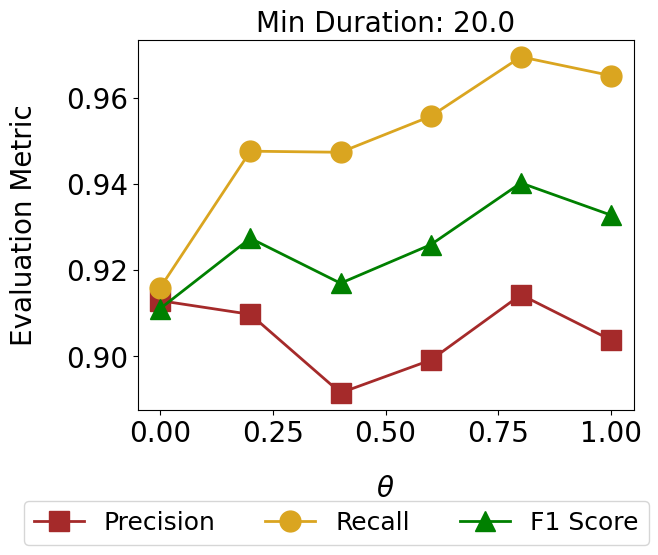

In [127]:
colors = ['brown', 'goldenrod', 'green']

precisions, recalls, f1scores = np.zeros(len(theta_list)), np.zeros(len(theta_list)), np.zeros(len(theta_list))

for j, theta in enumerate(theta_list):

    model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{theta}")

    precisions[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
    recalls[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
    f1scores[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

plt.plot(theta_list, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(theta_list, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(theta_list, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
plt.title(f"Min Duration: {window_duration}")
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)

plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.4,-0.4))
# plt.tight_layout()
plt.show()  

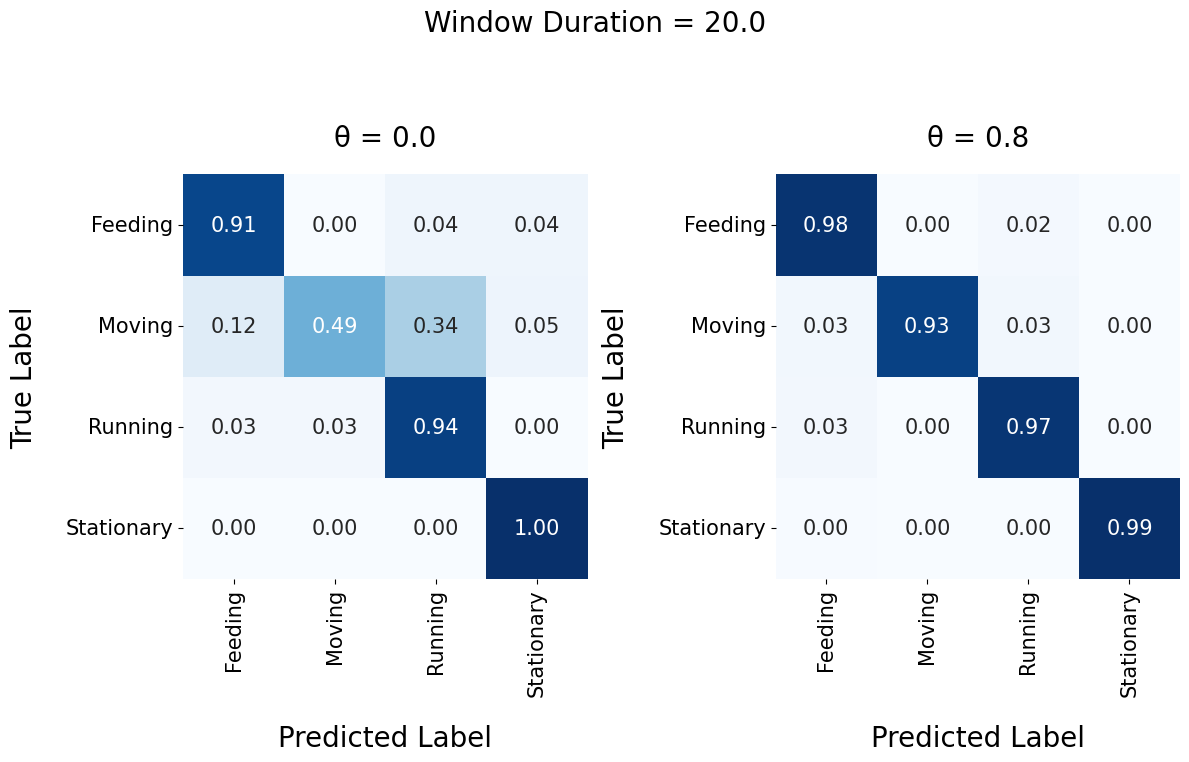

In [128]:
theta_list = [0.0, 0.8]
fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 8))

for i, theta in enumerate(theta_list):

    ax = axs[i]

    model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{theta}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')
    class_names = label_encoder.inverse_transform(np.arange(len(np.unique(val_true))))

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, square=True, linewidths=0,
                annot_kws={"size": 15}, ax=ax)

    ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
    ax.set_ylabel("True Label", fontsize=20, labelpad=20)
    ax.set_xticklabels(class_names, fontsize=15, rotation=90)
    ax.set_yticklabels(class_names, fontsize=15, rotation=0)
    ax.set_title(f"θ = {theta}", fontsize=20, pad=20)


fig.suptitle(f"Window Duration = {window_duration}", fontsize=20)
plt.tight_layout()
plt.show()

#### 2.3 Window Duration = 30.0

In [154]:
# create summary statistics data

window_duration = 30.0
X_train, y_train, X_val, y_val, X_test, y_test = create_data_splits(summary_acc_data_30, feature_cols=feature_cols)


In [155]:
theta_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for theta in theta_list:

    train_args.theta = theta

    # setup dataloaders
    train_dataloader, val_dataloader, test_dataloader = setup_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_args)

    # setup model, loss, and optimizer
    model = SimpleNN(input_dim=X_train.shape[1], n_ouputs=len(SUMMARY_BEHAVIORS_WO_TROTTING), hidden_layers=model_args.hidden_layers, dropout_rate=model_args.dropout_rate).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)

    #### Training
    train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, train_args, device)
    model = train_obj['model'].to(device)
    training_stats = train_obj['training_stats']

    model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{train_args.theta}")
    os.makedirs(model_dir, exist_ok=True)

    torch.save(model, os.path.join(model_dir, 'model.pt'))
    json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
    with open(json_training_stats_file, 'w') as f:
        json.dump(training_stats, f)

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
    np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
    np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
    np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
    np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])
    

Initializing...:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 100/100 | Train Loss: 0.0266 | Val Loss: 0.0221 | Best val Loss: 0.0221: 100%|██████████| 100/100 [00:06<00:00, 15.59it/s]


Total training time: 0:00:06


Epoch 100/100 | Train Loss: 0.0461 | Val Loss: 0.0135 | Best val Loss: 0.0135: 100%|██████████| 100/100 [00:07<00:00, 13.41it/s]


Total training time: 0:00:07


Epoch 100/100 | Train Loss: 0.0552 | Val Loss: 0.0103 | Best val Loss: 0.0103: 100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


Total training time: 0:00:07


Epoch 100/100 | Train Loss: 0.0700 | Val Loss: 0.0130 | Best val Loss: 0.0130: 100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


Total training time: 0:00:07


Epoch 100/100 | Train Loss: 0.0697 | Val Loss: 0.0107 | Best val Loss: 0.0107: 100%|██████████| 100/100 [00:07<00:00, 13.32it/s]


Total training time: 0:00:08


Epoch 100/100 | Train Loss: 0.0842 | Val Loss: 0.0152 | Best val Loss: 0.0152: 100%|██████████| 100/100 [00:06<00:00, 15.80it/s]


Total training time: 0:00:06


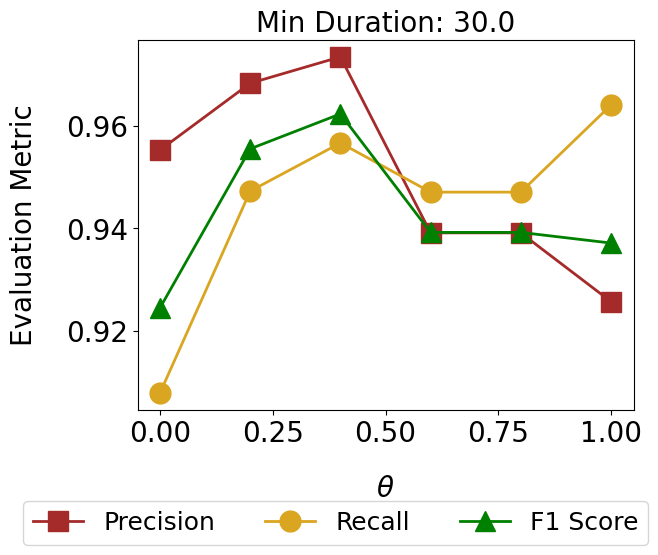

In [161]:
colors = ['brown', 'goldenrod', 'green']
theta_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

precisions, recalls, f1scores = np.zeros(len(theta_list)), np.zeros(len(theta_list)), np.zeros(len(theta_list))

for j, theta in enumerate(theta_list):

    model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{theta}")

    precisions[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
    recalls[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
    f1scores[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

plt.plot(theta_list, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(theta_list, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(theta_list, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
plt.title(f"Min Duration: {window_duration}")
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)

plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.4,-0.4))
# plt.tight_layout()
plt.show()  

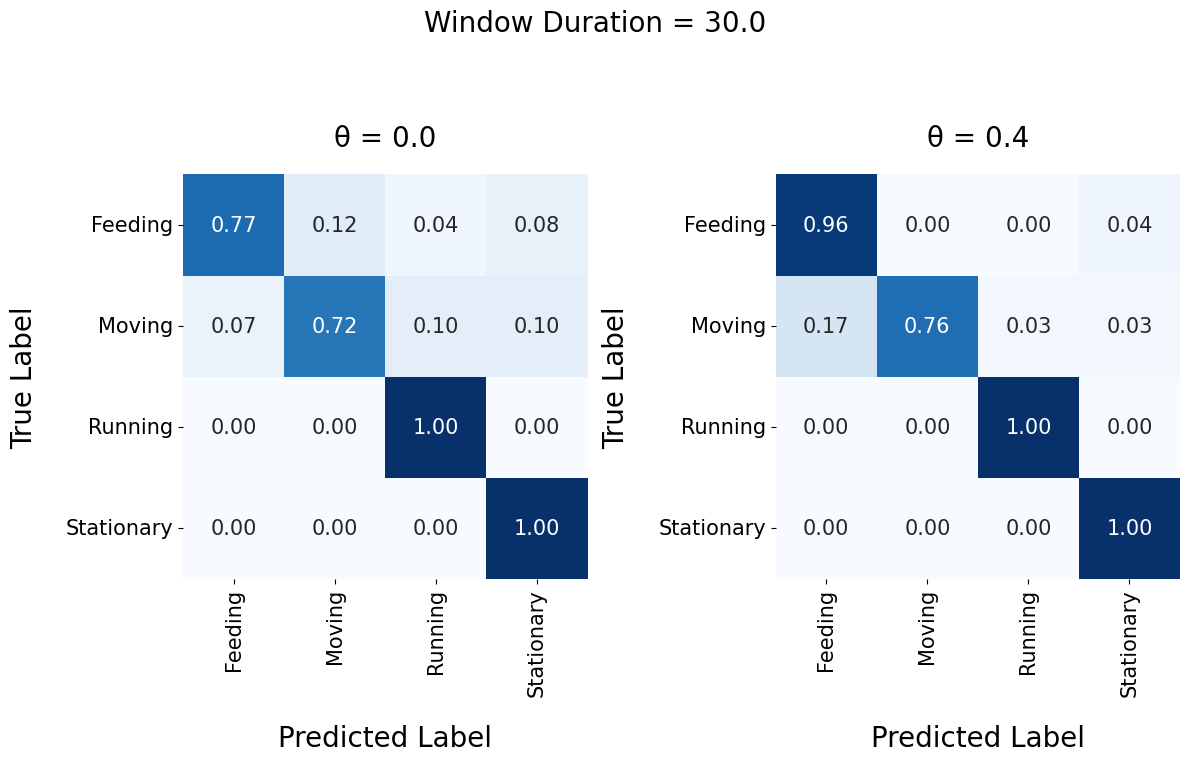

In [169]:
window_duration = 30.0
theta_list = [0.0, 0.4]
fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 8))

for i, theta in enumerate(theta_list):

    ax = axs[i]

    model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{theta}")
    test_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    test_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(test_true, test_predictions, normalize='true')
    class_names = label_encoder.inverse_transform(np.arange(len(np.unique(val_true))))

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, square=True, linewidths=0,
                annot_kws={"size": 15}, ax=ax)

    ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
    ax.set_ylabel("True Label", fontsize=20, labelpad=20)
    ax.set_xticklabels(class_names, fontsize=15, rotation=90)
    ax.set_yticklabels(class_names, fontsize=15, rotation=0)
    ax.set_title(f"θ = {theta}", fontsize=20, pad=20)


fig.suptitle(f"Window Duration = {window_duration}", fontsize=20)
plt.tight_layout()
plt.show()